In [2]:
import pandas as pd
import numpy as np
import requests
from sodapy import Socrata

In [7]:
#define parameters for endpoint, dataset, and app token
data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
app_token = 'dM7DDeidbAmgtydtJVV1epbiU'

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#create a loop to download the first 6000 records, save records in a dataframe
start = 0
chunk_size = 2000
results = []
while True:
    print(start)
    results.extend(client.get(dataset, limit=chunk_size))
    start = start+chunk_size
    if (start > 6000): #int(record_count[0]['COUNT'])):
        break
        
df = pd.DataFrame(results)

In [79]:
#count number of records in dataset
record_count = client.get(dataset, select='COUNT(*)')
record_count

[{'COUNT': '22725530'}]

In [80]:
#export downloaded data to csv for later access
df.to_csv('../data/311_data.csv', index=False)
newdata = pd.read_csv('../data/311_data.csv')
newdata

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,closed_date,resolution_description,resolution_action_updated_date,address_type,facility_type,bridge_highway_direction,road_ramp,bridge_highway_segment,taxi_company_borough,taxi_pick_up_location
0,46070760,2020-04-27T02:00:02.000,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,10473.0,635 CASTLE HILL AVENUE,CASTLE HILL AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,46071314,2020-04-27T01:59:21.000,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,11225.0,460 MONTGOMERY STREET,MONTGOMERY STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,46071244,2020-04-27T01:54:23.000,NYPD,New York City Police Department,Noise - Residential,Loud Television,Residential Building/House,10009.0,309 EAST 8 STREET,EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46070650,2020-04-27T01:51:16.000,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10040.0,99 HILLSIDE AVENUE,HILLSIDE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,46073379,2020-04-27T01:48:47.000,DHS,Department of Homeless Services,Homeless Person Assistance,NaN,NaN,11212.0,159 EAST 96 STREET,EAST 96 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,46074138,2020-04-26T14:32:49.000,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER SUPPLY,RESIDENTIAL BUILDING,11226.0,2305 BEDFORD AVENUE,BEDFORD AVENUE,...,NaN,The following complaint conditions are still o...,2020-04-26T00:00:00.000,ADDRESS,NaN,NaN,NaN,NaN,NaN,NaN
7996,46072197,2020-04-26T14:32:33.000,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10467.0,3039 WALLACE AVENUE,WALLACE AVENUE,...,2020-04-26T14:42:02.000,The Police Department responded and upon arriv...,2020-04-26T18:42:06.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7997,46073186,2020-04-26T14:32:09.000,DCA,Department of Consumer Affairs,Consumer Complaint,Retail Store,NaN,11385.0,71-62 69 PLACE,69 PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7998,46071419,2020-04-26T14:31:14.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10457.0,1511 SHERIDAN AVENUE,SHERIDAN AVENUE,...,NaN,The complaint you filed is a duplicate of a co...,2020-04-26T00:00:00.000,ADDRESS,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
newdata.columns

Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'city', 'landmark',
       'status', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       'closed_date', 'resolution_description',
       'resolution_action_updated_date', 'address_type', 'facility_type',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'taxi_company_borough', 'taxi_pick_up_location'],
      dtype='object')

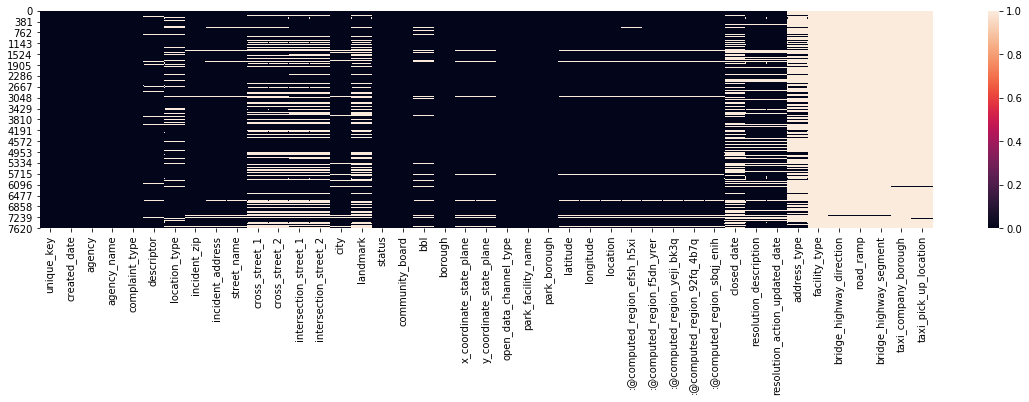

In [88]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rc('figure',figsize=(20,4))
sns.heatmap(newdata.isnull())